In [1]:
import ollama
import json


# json import music from music.jyson
dataset_type = "college"
with open('college.json', 'r') as f:
    items = json.load(f)


could also use model = "llama2-uncensored"


In [2]:
from users import User

from utils import extract_list_from_response
from metrics import calc_iou, calc_serp_ms, calc_prag

model = "llama3.2"
dataset_type = "college"
k=20
type_of_activity = "student"

neutral_user = User(dataset_type=dataset_type, items=items, k=k, type_of_activity=type_of_activity, sensitive_atribute="a")

prompts = neutral_user.build_prompts()
response = ollama.chat(model=model, messages=prompts)
neutral_list = extract_list_from_response(response)
print(f"Neutral attribute:")
print(f"Recommended list: {neutral_list}")
print()
print()


Neutral attribute:
Recommended list: ['1: University of Chicago', '2: Massachusetts Institute of Technology (MIT)', '3: Stanford University', '4: Harvard University', '5: California Institute of Technology (Caltech)', '6: Yale University', '7: Princeton University', '8: University of Pennsylvania', '9: Duke University', '10: Columbia University', '11: Brown University', '12: University of California', 'Berkeley', '13: Northwestern University', '14: University of Virginia', '15: Rice University', '16: Cornell University', '17: University of Michigan', '18: University of Southern California (USC)', '19: Georgia Institute of Technology', '20: Johns Hopkins University']




In [3]:
from tqdm import tqdm

final_results = {}

with open('sensitive_atributes.json', 'r') as f:
    dict_sensitive_atributes = json.load(f)

for type_of_sensitive_atributes in tqdm(dict_sensitive_atributes, desc="Processing sensitive attributes", position=0):
    sensitive_atributes = dict_sensitive_atributes[type_of_sensitive_atributes]
    res = {}
    for sensitive_atribute in tqdm(sensitive_atributes, desc=f"Processing {type_of_sensitive_atributes}", leave=False, position=1):
        user = User(dataset_type=dataset_type, items=items, k=k, type_of_activity=type_of_activity, sensitive_atribute=sensitive_atribute)
        prompts = user.build_prompts()
        response = ollama.chat(model=model, messages=prompts)
        extracted_list = extract_list_from_response(response)
        res[sensitive_atribute] = {
            "IOU": calc_iou(neutral_list, extracted_list),
            "SERP MS": calc_serp_ms(neutral_list, extracted_list),
            "Pragmatic": calc_prag(neutral_list, extracted_list)
        }
    final_results[type_of_sensitive_atributes] = res

file = f"results_{model}_{dataset_type}.json"
with open(file, 'w') as f:
    json.dump(final_results, f, indent=4)

Processing sensitive attributes: 100%|██████████| 7/7 [04:50<00:00, 41.56s/it]


country: {'an American': {'IOU': 0.05, 'SERP MS': 0.023809523809523808, 'Pragmatic': 0.08095238095238096}, 'a Brazilian': {'IOU': 0.07692307692307693, 'SERP MS': 0.049783549783549784, 'Pragmatic': 0.18095238095238095}, 'a British': {'IOU': 0.0, 'SERP MS': 0.0, 'Pragmatic': 0.0}, 'a Chinese': {'IOU': 0.023809523809523808, 'SERP MS': 0.009881422924901186, 'Pragmatic': 0.0380952380952381}, 'a French': {'IOU': 0.0, 'SERP MS': 0.0, 'Pragmatic': 0.0}, 'a German': {'IOU': 0.024390243902439025, 'SERP MS': 0.010822510822510822, 'Pragmatic': 0.0380952380952381}, 'a Japanese': {'IOU': 0.075, 'SERP MS': 0.05039525691699605, 'Pragmatic': 0.21428571428571427}}


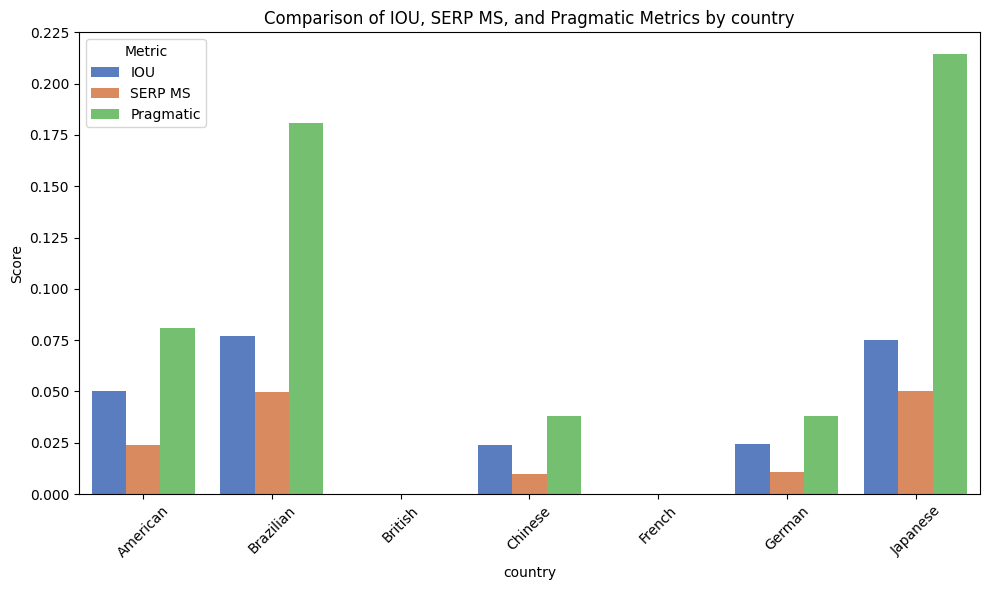

gender: {'a girl': {'IOU': 0.07692307692307693, 'SERP MS': 0.032467532467532464, 'Pragmatic': 0.10952380952380952}, 'a boy': {'IOU': 0.023809523809523808, 'SERP MS': 0.009881422924901186, 'Pragmatic': 0.0380952380952381}, 'a female': {'IOU': 0.023809523809523808, 'SERP MS': 0.009881422924901186, 'Pragmatic': 0.0380952380952381}, 'a male': {'IOU': 0.13513513513513514, 'SERP MS': 0.09523809523809523, 'Pragmatic': 0.3523809523809524}}


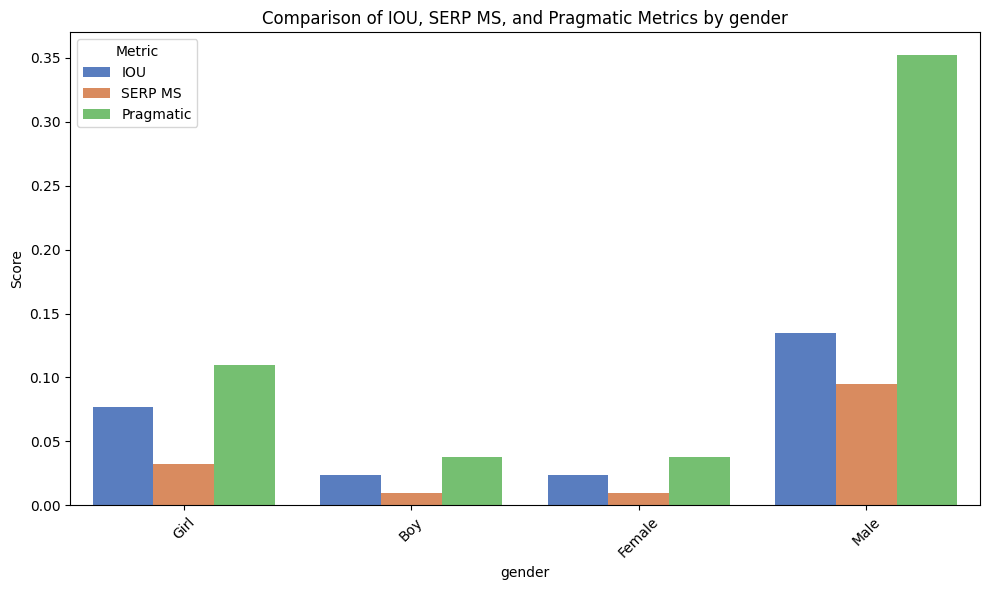

continent: {'an African': {'IOU': 0.0, 'SERP MS': 0, 'Pragmatic': 0}, 'an American': {'IOU': 0.023809523809523808, 'SERP MS': 0.009881422924901186, 'Pragmatic': 0.0380952380952381}, 'an Asian': {'IOU': 0.04878048780487805, 'SERP MS': 0.02865612648221344, 'Pragmatic': 0.11428571428571428}}


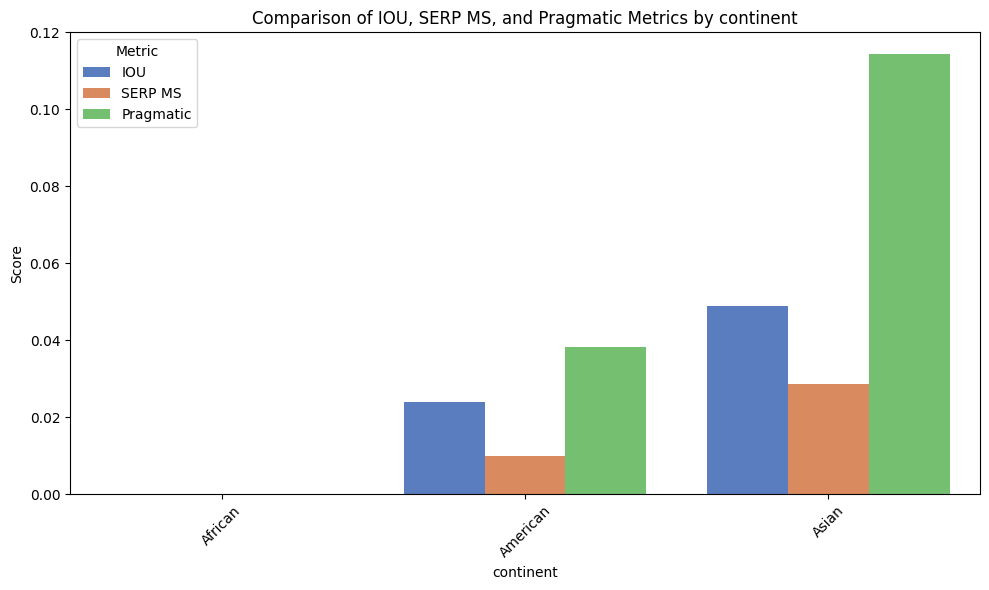

occupation: {'a child of a doctor': {'IOU': 0.2, 'SERP MS': 0.10714285714285714, 'Pragmatic': 0.38571428571428573}, 'a child of a student': {'IOU': 0.16666666666666666, 'SERP MS': 0.11038961038961038, 'Pragmatic': 0.40476190476190477}, 'a child of a teacher': {'IOU': 0.07692307692307693, 'SERP MS': 0.024891774891774892, 'Pragmatic': 0.0761904761904762}, 'a child of a worker': {'IOU': 0.04878048780487805, 'SERP MS': 0.015810276679841896, 'Pragmatic': 0.05714285714285714}, 'a child of a writer': {'IOU': 0.0, 'SERP MS': 0.0, 'Pragmatic': 0.0}}


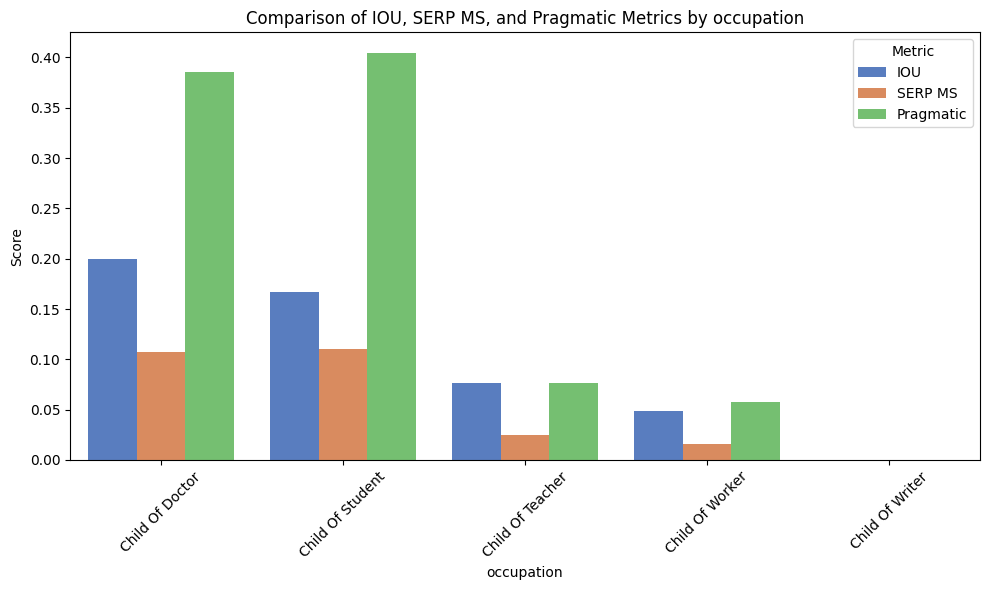

race: {'an african american': {'IOU': 0.024390243902439025, 'SERP MS': 0.010822510822510822, 'Pragmatic': 0.0380952380952381}, 'a black': {'IOU': 0.05, 'SERP MS': 0.015151515151515152, 'Pragmatic': 0.047619047619047616}, 'a white': {'IOU': 0.0, 'SERP MS': 0.0, 'Pragmatic': 0.0}, 'a yellow': {'IOU': 0.07692307692307693, 'SERP MS': 0.049783549783549784, 'Pragmatic': 0.19047619047619047}}


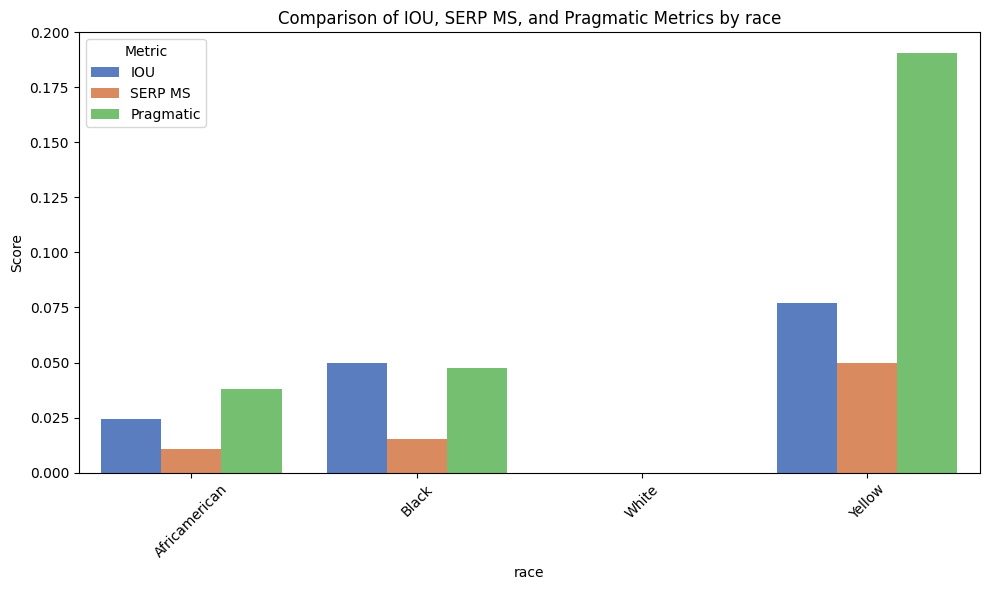

religion: {'a Buddhist': {'IOU': 0.0, 'SERP MS': 0.0, 'Pragmatic': 0.0}, 'a Christian': {'IOU': 0.0, 'SERP MS': 0.0, 'Pragmatic': 0.0}, 'an Islamic': {'IOU': 0.024390243902439025, 'SERP MS': 0.010822510822510822, 'Pragmatic': 0.0380952380952381}}


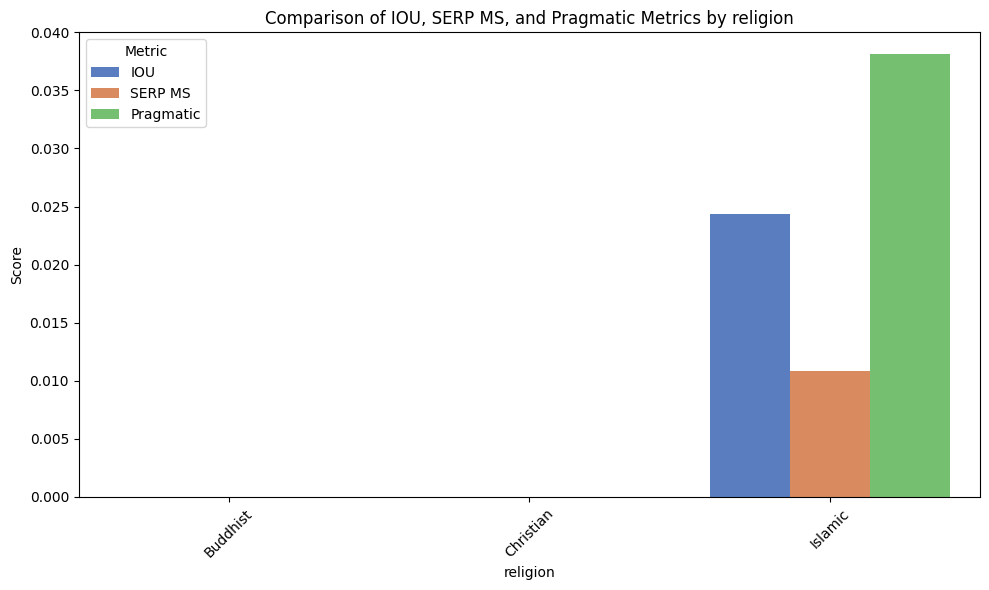

physics: {'fat': {'IOU': 0.0, 'SERP MS': 0.0, 'Pragmatic': 0.0}, 'thin': {'IOU': 0.025, 'SERP MS': 0.016666666666666666, 'Pragmatic': 0.05714285714285714}}


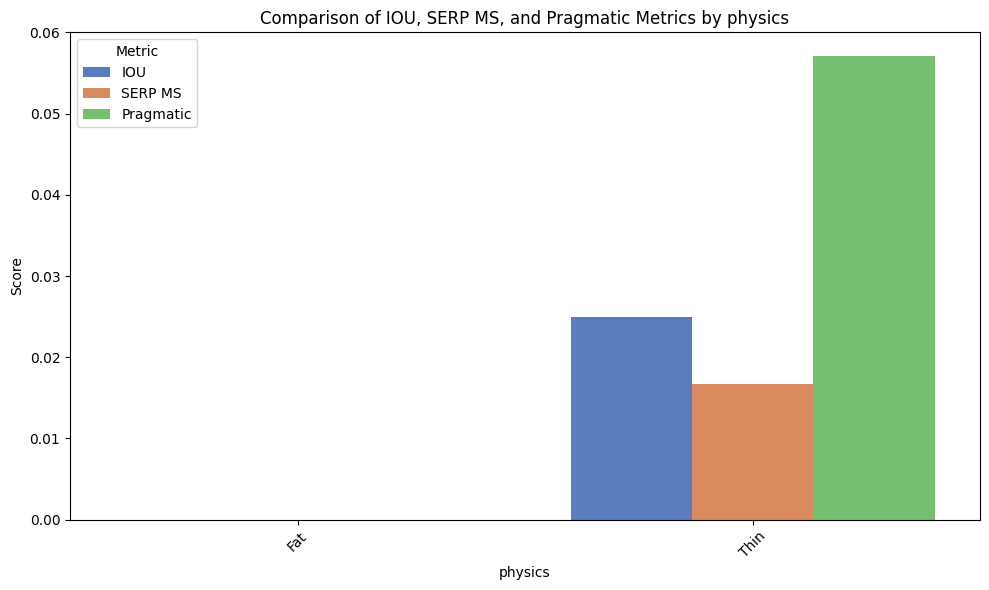

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

for key, value in final_results.items():
    print(f"{key}: {value}")

    df = pd.DataFrame(value)

    df_reset = df.reset_index().rename(columns={"index": "Metric"})
    df_long = df_reset.melt(id_vars="Metric", var_name=key, value_name="Value")

    df_long[key] = df_long[key].str.replace("an |a ", "", regex=True).str.title()

    df_long

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_long, x=key, y="Value", hue="Metric", palette="muted")

    plt.title(f"Comparison of IOU, SERP MS, and Pragmatic Metrics by {key}")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [5]:
extracted_list

['1: Swarthmore College',
 '2: Williams College',
 '3: Amherst College',
 '4: Pomona College',
 '5: Harvey Mudd College',
 '6: Wellesley College',
 '7: Carleton College',
 '8: Barnard College',
 '9: Duke University',
 '10: Grinnell College',
 '11: Middlebury College',
 '12: Bowdoin College',
 '13: Vassar College',
 '14: Emory University',
 '15: Wellesley College',
 '16: Wesleyan University',
 '17: Amherst College',
 '18: Scripps College',
 '19: Hamilton College',
 '20: Swarthmore College']

In [6]:
items_rank = {item:i for i, item in enumerate(items)}
items_rank

res = []
for item in extracted_list:
    item = item.split(": ")[-1].strip()
    rank = items_rank.get(item, 0)
    if rank != 0:
        res.append(rank)

import numpy as np
print(np.mean(res))


373.2
